##### Unziping data

In [ ]:
# Takes about one minute to unzip
!unzip -q train.zip
!unzip -q val.zip

In [1]:
!unzip -q "train (2).zip"
!unzip -q "val (2).zip"

In [2]:
# Renaming val folder to test
!mv val test

##### Libraries

In [1]:
# For obtaining files from directory
import os

# Data science libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Future models if time allows
from keras.applications.xception import Xception
from keras.applications.resnet_v2 import ResNet152V2

# For evaluating model
from sklearn.metrics import classification_report

# For loading bar
from tqdm import tqdm

Using TensorFlow backend.


##### Functions for evaluating models

In [2]:
def showPerformancePlots(train_p, val_p, dataset_name):
    epochs = range(1, len(train_p) + 1)

    plt.plot(epochs, train_p)
    plt.plot(epochs, val_p)
    plt.title(dataset_name + " over Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend(['Train' ,'Validation'])

    plt.figure()

    plt.show()

In [3]:
def printClassificationReport(train_ds, test_ds, y_pred):
    # Creating a dict that maps the label digit to their name
    labels = (train_ds.class_indices)
    labels = dict((v,k) for k,v in labels.items())

    # Getting the label names from each prediction made
    y_pred_labels = [labels[k] for k in y_pred]

    # Getting the label names from the test images
    y_test_labels = test_ds.labels
    y_test_labels = [labels[k] for k in y_test_labels]

    print(classification_report(y_test_labels, y_pred_labels))

In [4]:
def plotConfusionMatrix(train_ds, test_ds, y_pred, color = "YlGnBu"):
    # Getting label digits from test images and from predicted results
    y_test_keys = test_ds.labels
    y_pred_keys = y_pred

    # Used to label x and y axis of confusion matrix
    label_names = list(train_ds.class_indices.keys())

    # Creates a matrix
    confusion_mtx = tf.math.confusion_matrix(y_test_keys, y_pred_keys) 

    # Making the matrix a confusion matrix
    plt.subplots(figsize=(10,10))

    sns.heatmap(
      confusion_mtx,
      annot = True,
      xticklabels = label_names,
      yticklabels = label_names,
      cmap = color
    )

    plt.show()

In [5]:
def predictTest(model, test_path):
    labels = os.listdir(test_path)
    labels.sort()
    
    label_folders = []
    y_pred_list = []
 
    for i in range(len(labels)):
        label_folders.append(os.path.join(test_path, labels[i]))
    
    for folder in tqdm(label_folders):
        # "images" contains a list of all of the image names inside the folder
        # Example: ["00001.jpg", "00002.jpg", ...] 
        images = os.listdir(folder)
        images.sort()
        
        for img in images:
            img_path = os.path.join(folder, img)
            # "img_path" example = "/content/train/beach/00001.jpg"
            
            proc_img = tf.keras.preprocessing.image.load_img(path=img_path , target_size=(256, 256))
            input_arr = tf.keras.preprocessing.image.img_to_array(proc_img)
            img_batch = np.expand_dims(input_arr, axis=0)

            image_preprocessed = tf.keras.applications.xception.preprocess_input(img_batch)
            y_pred = model.predict(image_preprocessed)
            y_pred = np.argmax(y_pred)
            y_pred_list.append(y_pred)

    return np.array(y_pred_list)
            
    
    

##### Loading Data

In [6]:
img_size = (256, 256)
train_dir = "train"
test_dir = "test"

In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    rotation_range = 20,
    horizontal_flip=True,
    validation_split = 0.1
)

In [8]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255
)

In [9]:
train_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    color_mode = "rgb",
    batch_size = 128,
    class_mode = "categorical",
    subset = "training",
    shuffle = True,
    seed = 123
)

Found 89908 images belonging to 20 classes.


In [10]:
val_ds = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    color_mode = "rgb",
    batch_size = 128,
    class_mode = "categorical",
    subset = "validation",
    shuffle = True,
    seed = 123
)

Found 9988 images belonging to 20 classes.


In [11]:
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    color_mode = "rgb",
    batch_size = 128,
    class_mode = "categorical",
    shuffle = True
)

Found 2000 images belonging to 20 classes.


In [12]:
# Sanity check
print("train_ds shape:", train_ds.image_shape)
print("test_ds shape:", test_ds.image_shape)

train_ds shape: (256, 256, 3)
test_ds shape: (256, 256, 3)


## Transfer learning with Xception model

In [13]:
base_model = Xception(include_top = False, weights="imagenet", input_shape=(256, 256, 3))

In [14]:
# Last 20% is trainable
train_layers_num = len(base_model.layers) // 5

for layer in base_model.layers[:-(train_layers_num)]:
    layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_1,False
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,False
2,<tensorflow.python.keras.layers.normalization_...,block1_conv1_bn,False
3,<tensorflow.python.keras.layers.core.Activatio...,block1_conv1_act,False
4,<tensorflow.python.keras.layers.convolutional....,block1_conv2,False
...,...,...,...
127,<tensorflow.python.keras.layers.normalization_...,block14_sepconv1_bn,True
128,<tensorflow.python.keras.layers.core.Activatio...,block14_sepconv1_act,True
129,<tensorflow.python.keras.layers.convolutional....,block14_sepconv2,True
130,<tensorflow.python.keras.layers.normalization_...,block14_sepconv2_bn,True


In [15]:
inputs = base_model.input

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(20, activation='softmax')(x)

In [16]:
model = tf.keras.Model(inputs, outputs)

In [17]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(), 
    loss = "categorical_crossentropy", 
    metrics = ["acc"]
)

In [18]:
epochs = 6
history = model.fit(train_ds, 
                    epochs=epochs,
                    validation_data=val_ds
)

Epoch 1/6
703/703 [==============================] - 3686s 5s/step - loss: 1.6025 - acc: 0.5562 - val_loss: 0.8966 - val_acc: 0.7485
Epoch 2/6
703/703 [==============================] - 1566s 2s/step - loss: 0.9872 - acc: 0.7359 - val_loss: 0.8536 - val_acc: 0.7585
Epoch 3/6
703/703 [==============================] - 1584s 2s/step - loss: 0.8864 - acc: 0.7598 - val_loss: 0.8439 - val_acc: 0.7640
Epoch 4/6
703/703 [==============================] - 1573s 2s/step - loss: 0.8212 - acc: 0.7735 - val_loss: 0.7926 - val_acc: 0.7737
Epoch 5/6
703/703 [==============================] - 1581s 2s/step - loss: 0.7793 - acc: 0.7842 - val_loss: 0.8147 - val_acc: 0.7672
Epoch 6/6
703/703 [==============================] - 1566s 2s/step - loss: 0.7264 - acc: 0.7972 - val_loss: 0.8139 - val_acc: 0.7655


#### Evaluating Xception model

In [19]:
# Getting evaluation stats
model.evaluate(test_ds)

16/16 [==============================] - 25s 2s/step - loss: 0.7413 - acc: 0.7750


[0.741252601146698, 0.7749999761581421]

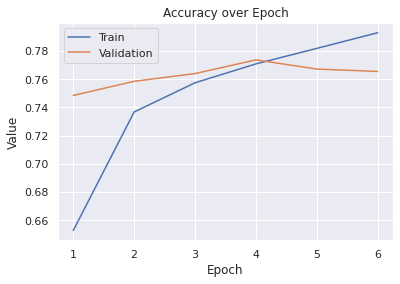

<Figure size 432x288 with 0 Axes>

In [20]:
# PLotting accuracy and loss change over epoch
acc = history.history["acc"]
val_acc = history.history["val_acc"]

showPerformancePlots(acc, val_acc, "Accuracy")

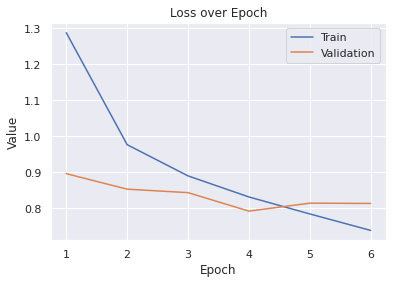

<Figure size 432x288 with 0 Axes>

In [21]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

showPerformancePlots(loss, val_loss, "Loss")

In [22]:
# Predicting model
y_pred = predictTest(model, "test")

100%|██████████| 20/20 [02:12<00:00,  6.63s/it]


In [23]:
# Classification report
printClassificationReport(train_ds, test_ds, y_pred)

              precision    recall  f1-score   support

       alley       0.79      0.96      0.87       100
      bridge       0.80      0.68      0.74       100
      canyon       0.62      0.71      0.66       100
 desert-sand       0.90      0.76      0.83       100
    downtown       0.73      0.79      0.76       100
      forest       0.88      0.80      0.84       100
      grotto       0.75      0.95      0.84       100
     iceberg       0.89      0.87      0.88       100
lake-natural       0.69      0.66      0.67       100
    mountain       0.58      0.53      0.55       100
       ocean       0.65      0.71      0.68       100
        park       0.90      0.76      0.83       100
   rock_arch       0.82      0.83      0.83       100
        ruin       0.80      0.74      0.77       100
         sky       0.76      0.68      0.72       100
   snowfield       0.84      0.87      0.85       100
      street       0.89      0.79      0.84       100
       tower       0.72    

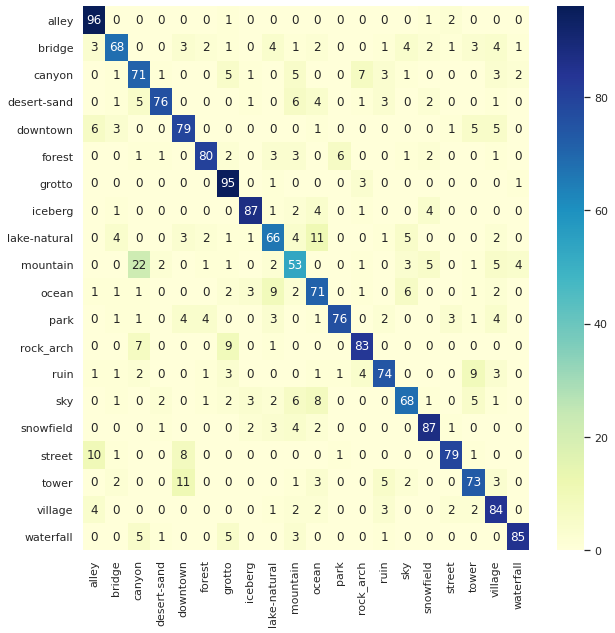

In [24]:
## Confusion matrix
plotConfusionMatrix(train_ds, test_ds, y_pred, color = "YlGnBu")

#### Saving Xception model

In [25]:
## Saving model

json_model = model.to_json()

with open('xception_model.json', 'w') as json_file:
    json_file.write(json_model)

# Saving the weights
model.save_weights('xception_weights.h5')


## Transfer Learning with ResNet15V2 model

In [26]:
base_model = ResNet152V2(include_top = False, weights="imagenet", input_shape=(256, 256, 3))

In [27]:
# Last 20% is trainable
train_layers_num = len(base_model.layers) // 5

for layer in base_model.layers[:-(train_layers_num)]:
    layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_2,False
1,<tensorflow.python.keras.layers.convolutional....,conv1_pad,False
2,<tensorflow.python.keras.layers.convolutional....,conv1_conv,False
3,<tensorflow.python.keras.layers.convolutional....,pool1_pad,False
4,<tensorflow.python.keras.layers.pooling.MaxPoo...,pool1_pool,False
...,...,...,...
559,<tensorflow.python.keras.layers.core.Activatio...,conv5_block3_2_relu,True
560,<tensorflow.python.keras.layers.convolutional....,conv5_block3_3_conv,True
561,<tensorflow.python.keras.layers.merge.Add obje...,conv5_block3_out,True
562,<tensorflow.python.keras.layers.normalization_...,post_bn,True


In [28]:
inputs = base_model.input

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(20, activation='softmax')(x)

In [29]:
model = tf.keras.Model(inputs, outputs)

In [30]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(), 
    loss = "categorical_crossentropy", 
    metrics = ["acc"]
)

In [31]:
epochs = 6
history = model.fit(train_ds, 
                    epochs=epochs,
                    validation_data=val_ds
)

Epoch 1/6
703/703 [==============================] - 2259s 3s/step - loss: 1.7848 - acc: 0.4973 - val_loss: 0.9792 - val_acc: 0.7213
Epoch 2/6
703/703 [==============================] - 2230s 3s/step - loss: 1.0400 - acc: 0.7147 - val_loss: 0.8864 - val_acc: 0.7470
Epoch 3/6
703/703 [==============================] - 2232s 3s/step - loss: 0.9314 - acc: 0.7437 - val_loss: 0.9163 - val_acc: 0.7431
Epoch 4/6
703/703 [==============================] - 2223s 3s/step - loss: 0.8502 - acc: 0.7583 - val_loss: 0.8019 - val_acc: 0.7655
Epoch 5/6
703/703 [==============================] - 2227s 3s/step - loss: 0.8153 - acc: 0.7734 - val_loss: 0.8179 - val_acc: 0.7626
Epoch 6/6
703/703 [==============================] - 2232s 3s/step - loss: 0.7579 - acc: 0.7855 - val_loss: 0.8189 - val_acc: 0.7642


#### Evaluating ResNet15V2 model

In [32]:
# Getting evaluation stats
model.evaluate(test_ds)

16/16 [==============================] - 36s 2s/step - loss: 0.7639 - acc: 0.7690


[0.7638925313949585, 0.7689999938011169]

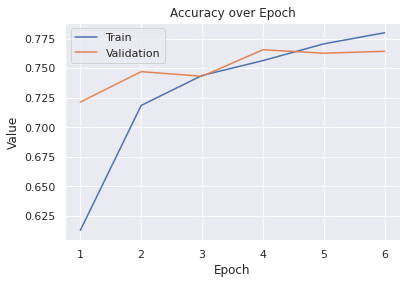

<Figure size 432x288 with 0 Axes>

In [33]:
# PLotting accuracy and loss change over epoch
acc = history.history["acc"]
val_acc = history.history["val_acc"]

showPerformancePlots(acc, val_acc, "Accuracy")

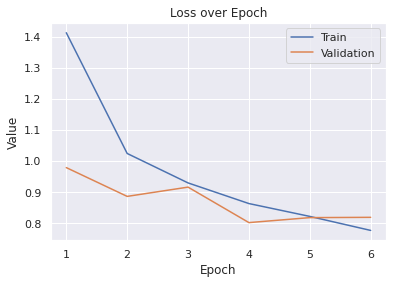

<Figure size 432x288 with 0 Axes>

In [34]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

showPerformancePlots(loss, val_loss, "Loss")

In [35]:
# Predicting model
y_pred = predictTest(model, "test")

100%|██████████| 20/20 [03:14<00:00,  9.73s/it]


In [36]:
# Classification report
printClassificationReport(train_ds, test_ds, y_pred)

              precision    recall  f1-score   support

       alley       0.91      0.87      0.89       100
      bridge       0.94      0.59      0.72       100
      canyon       0.77      0.57      0.66       100
 desert-sand       0.81      0.77      0.79       100
    downtown       0.79      0.82      0.80       100
      forest       0.77      0.82      0.80       100
      grotto       0.79      0.90      0.84       100
     iceberg       0.91      0.80      0.85       100
lake-natural       0.72      0.62      0.67       100
    mountain       0.52      0.64      0.57       100
       ocean       0.65      0.71      0.68       100
        park       0.74      0.81      0.77       100
   rock_arch       0.84      0.81      0.83       100
        ruin       0.73      0.79      0.76       100
         sky       0.59      0.74      0.66       100
   snowfield       0.87      0.74      0.80       100
      street       0.84      0.76      0.80       100
       tower       0.72    

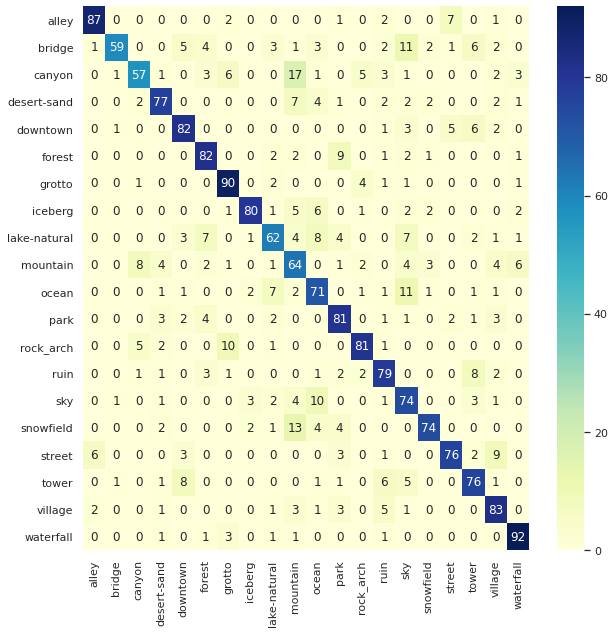

In [37]:
## Confusion matrix
plotConfusionMatrix(train_ds, test_ds, y_pred, color = "YlGnBu")

#### Saving ResNet15V2

In [38]:
## Saving model

json_model = model.to_json()

with open('resnet_model.json', 'w') as json_file:
    json_file.write(json_model)

# Saving the weights
model.save_weights('resnet_weights.h5')
